# Blood Glucose Model


## Extended Bergman Minimal Model

```
Ramiro Paloma (2013) "Estimation and personalization of clinical insulin therapy parameters" Ch PhD Thesis, The University of Texas at Austin http://hdl.handle.net/2152/21375
```  

- Normal resting blood glucose levels are between 70 and 100 mg/dL. The goal of an insulin controller is to curb hyperglycemia of 135+ mg/dL and eliminate the more dangerous hypoglycemia with blood glucose levels of 60 mg/dL or lower.
- Identifies three parameters that must be identified for each patient: basal insulin dose, insulin sensitivity factor, and insulin-to-carbohydrate ratio
- Transport of Glucose across the cell membrane isthe rate-limiting step in glucose utilization. Insulin increases proportion of GLUT4 -- The primary glucose transport protien present on cell surfaces. After glucose is transported across the cell membrane, it is either used in ATP synthesis or stored as glycogen or fat. In mammals, up to 90% of all glucose metabolism is mediated and controlled by insulin.

**Manipulated Variables/Inputs**  

$D(t)$ - Ingested glucose uptake (g)  
$U(t)$ - Subcutaneous insulin infusion rate (U/min)  
- Bound between 0 and 0.100 U/min
- -16 mU $\le \Delta U(t) \le$ 16mU
- Random walk that satisfies these conditions subject to the following basic control scheme:
  - If G $<$ *insulin limit*: ramp insulin down to 0 and maintain there for the next 45 minutes
  - If G $<$ *dangerously low glucose level*: ingest 2g of carbs per minute  

**States**  
$X(t)$ - Remote Insulin (U/L)  
$I(t)$ - Blood Plasma Insulin Concentration (U/L)  
$G(t)$ - Blood Plasma Glucose Concentration (mg/dL)  
$q_1(t)$ - Mass Carbohydrate in stomach compartment 1  (g)  
$q_2(t)$ - Mass Carbohydrate in stomach compartment 2  (g)  
$G_{gut}(t)$ - Mass Carbohydrate in the gut  (g)  

**Parameters \& [uncertainty]**  
$p_1$ - 1.57 $\times 10^{-2}$ [$1.0\times10^{-3}$] (1/min)  
$G_b$ - 100  [7.9] (mg/dl)  
$p_2$ - $1.23 \times 10^{-2}$ [$4.3\times 10^{-4}$] (1/min)  
$s_i$ - $5.0 \times 10^{-1}$ [$1.1\times 10^{-2}$] (L/min-U)  
$k_e$ - $1.82\times10^{-2}$ [$5.2\times 10^{-4}$] (1/min)  
$k_{abs}$ - $1.2\times10^{-2}$ [$3.8\times 10^{-4}$] (1/min)  
$k_{emp}$ - $1.8\times10^{-1}$ [$1.5\times 10^{-2}$] (1/min)  
$V_i(L)$ - 12 [$3.0\times10^{-1}$] (L)  
$\frac{fk_{abs}}{V_G}$ - $8.0\times10^{-2}$ [$2.0\times10^{-3}$] (mg/dL-min-gCHO)  
$I_b$ - $4.0\times10^{-2}$ [$2.0\times10^{-3}$] (U/L)   


$\frac{dG(t)}{dt}=-p_1(G(t)-G_b)-s_iX(t)G(t)+\frac{fk_{abs}}{V_G}G_{gut}$  
$\frac{dX(t)}{dt}=-p_2(X(t) - I(t) - I_b)$  
$\frac{dI(t)}{dt}=U(t) - k_eI(t)$  
$\frac{dq_1(t)}{dt}=D(t)-k_{emp}q_1(t)$  
$\frac{dq_2(t)}{dt}=k_{emp}(q_1(t)-q_2(t))$  
$\frac{dG_{gut}(t)}{dt}=k_{emp}q_2(t)-k_{abs}G_{gut}(t)$  




In [1]:
import datetime
import os
from typing import Optional, Union

from labellines import labelLine, labelLines
import matplotlib as mpl
import matplotlib.pyplot as plt
from neuromancer.psl.signals import nd_walk, step
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import sklearn.preprocessing as skp
import torch
from tqdm.notebook import tqdm

from utils import *
from utils.modeling import EarlyStopper, Exogenous_RkRNN
from utils.modeling import init_weights, MyCosineAnnealingWarmRestartsWithWarmup, get_jacobian, get_parameter_gradient_vector
from utils.optimizers import GEKF
from utils.glucose import DiabeticPatient, GlucoseDataset
from utils.glucose import get_glucose_data, train_minibatch, val_epoch, train_model, train_model_config, plot_prediction
from utils.glucose import DATA_STEP_SIZE

results_dir = os.path.join("results", "glucosev3")
os.makedirs(results_dir, exist_ok=True)
sns.set_context("paper")
logger = h5_logger(os.path.join(results_dir, "data.h5"))

NOISE_STD = 0.01  # noise level after scaling
device = torch.device("cpu")

Generate Data

In [2]:
if not logger.check_key("training/data/t"):
# if True:

    days = 2000
    
    P = DiabeticPatient(param_kwargs={"Ib":1e-2})
    
    d = P.get_d(days)
        
    # create time array
    t = np.arange(len(d))

    # insulin
    # 2000 days
    # 1600 training : 200 validation : 200 test
    # 
    u = nd_walk(
        nsim=len(t),
        d=1,
        min=0,
        max=0.1,
        x0=0,
        max_step=0.016,
        p=0.01,
        avoid_edge=False,
        granularity=0
    )[:,0]
    uc = u.copy()

    y0 = np.array([P.Gb, P.Ib, P.Ib, 0, 0, 0, P.Gb, P.si, P.Ib])

    Y = P.sim_safe_patient(y0, t, u, d, [0, 0, 0])
    
    Y = np.array(Y, dtype=np.float32)
    
    G, X, I, Q1, Q2, G_gut, _, _, _ = Y.T
        
    logger.log_dict({
        "training/data/t": t,
        "training/data/D": d,
        "training/data/U": u,
        "training/data/G": G,
        "training/data/X": X,
        "training/data/I": I,
        "training/data/Q1": Q1,
        "training/data/Q2": Q2,
        "training/data/G_gut": G_gut
    })

# training data with noise
if not logger.check_key("training/data w noise/t"):
    data = get_glucose_data(logger, base_key="training/data")
    noisy_data = {}
    for k, v in data.items():
        if k == "t":
            noisy_data["training/data w noise/"+k] = v
        else:
            noisy_data["training/data w noise/"+k] = v + np.random.normal(0, NOISE_STD, v.shape) * np.std(v)
            
    logger.log_dict(noisy_data)


datasets and dataloaders

In [3]:
data = get_glucose_data(logger, "training/data w noise")
Xscaler = skp.StandardScaler()
Uscaler = skp.StandardScaler()

train_dataset = GlucoseDataset(data,
    prediction_horizon=60,
    input_horizon=1,
    step_size=DATA_STEP_SIZE,
    databounds=[0, 0.8],
    train=True,
    Xscaler=Xscaler,
    Uscaler=Uscaler
)
val_dataset = GlucoseDataset(data,
    prediction_horizon=60,
    input_horizon=1,
    step_size=DATA_STEP_SIZE,
    databounds=[0.8, 0.9],
    Xscaler=Xscaler,
    Uscaler=Uscaler
)
test_dataset = GlucoseDataset(data,
    prediction_horizon=60,
    input_horizon=1,
    step_size=DATA_STEP_SIZE,
    databounds=[0.9, 1],
    Xscaler=Xscaler,
    Uscaler=Uscaler
)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, generator=torch.Generator(device=device))
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True, generator=torch.Generator(device=device))
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(val_dataset), shuffle=True, generator=torch.Generator(device=device))

print(f"Windows: Train: {train_dataset.n_windows:,}, Val: {val_dataset.n_windows:,}, Test: {test_dataset.n_windows:,}")
# print(f"Years: Train: {train_dataset.n_windows/1440/365*DATA_STEP_SIZE:.2f}, Val: {val_dataset.n_windows/1440/365*DATA_STEP_SIZE:.2f}, Test: {test_dataset.n_windows/1440/365*DATA_STEP_SIZE:.2f}")

# model = torch.load(os.path.join(results_dir, "model.pth")).to(device)

Windows: Train: 23,039, Val: 2,879, Test: 2,880


Training hyperparameter sweep

In [4]:
if not os.path.exists(os.path.join(results_dir, "model.pth")):
    lr = 1e-2
    bs = 2**11
    ls = 32

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=bs, shuffle=True, generator=torch.Generator(device=device))
    early_stopper = EarlyStopper(patience=25)
    model = Exogenous_RkRNN(6,2,ls)
    model.apply(init_weights)
    model.to(device)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
    checkpointing = True

    train_losses = []
    val_losses = []
    lrs = []
    epoch = 0
    while not early_stopper():
        model.train()
        running_loss = 0
        for i, batch in enumerate(train_dataloader):
            X0 = batch['X0']
            U = batch['U']
            X = batch['X']
            
            loss = train_minibatch(model, X0, U, X, criterion, optimizer)
            running_loss += loss
            
            print(f"\rEpoch [{epoch+1}], Minibatch [{str(i+1).zfill(2)}/{len(train_dataloader)}] Train: {0 if len(train_losses) == 0 else train_losses[-1]:.4g} Val: {0 if len(val_losses) == 0 else val_losses[-1]:.4g} lr: {lr_scheduler.get_last_lr()[0]:.2g}, patience: {early_stopper.counter}",end="")

        
        # train_loss = running_loss / len(train_dataloader)
        train_loss = val_epoch(model, train_dataloader, criterion)
        val_loss = val_epoch(model, val_dataloader, criterion)
        
        lr_scheduler.step(train_loss)
        early_stopper.step(val_loss)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        lrs.append(lr_scheduler.get_last_lr())
        
        # checkpointing
        if checkpointing:
            if train_losses[-1] == min(train_losses):
                checkpoint = model.state_dict().copy()
        
        print(f"\rEpoch [{epoch+1}], Minibatch [{i+1}/{len(train_dataloader)}] Train: {0 if len(train_losses) == 0 else train_losses[-1]:.4g} Val: {0 if len(val_losses) == 0 else val_losses[-1]:.4g} lr: {lr_scheduler.get_last_lr()[0]:.2g}, patience: {early_stopper.counter}",end="")
        epoch += 1
        
    torch.save(model, os.path.join(results_dir, "model.pth"))
    
else:
    model = torch.load(os.path.join(results_dir, "model.pth")).to(device)

C:\Users\jhamm\AppData\Local\Temp\ipykernel_30564\2544051953.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(results_dir, "model.pth")).

In [5]:
# model.load_state_dict(checkpoint) 
# torch.save(model, os.path.join(results_dir, "model-PC.pt"))

In [6]:
# hyperparameter_search_dir = os.path.join(results_dir, "training", "hyperparameter search 1")

# # learning_rates = [1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
# # batch_sizes = [2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
# # layer_sizes = [32, 64, 128, 256, 512]
# learning_rates = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1]  # 5
# batch_sizes = [2**10,  2**12, 2**14]  # 3
# layer_sizes = [32, 64, 128]  # 3
# n_epochs_ = [150, 300]  # 2

# training_configs = []

# for lr in learning_rates:
#     for bs in batch_sizes:
#         for ls in layer_sizes:
#             for ne in n_epochs_:
#                 model_string = f"model_lr_{lr}_bs_{bs}_ls_{ls}_ne_{ne}.pt"
#                 losses_string = f"losses_lr_{lr}_bs_{bs}_ls_{ls}_ne_{ne}.npz"
#                 if not os.path.exists(os.path.join(hyperparameter_search_dir, model_string)):
#                     print(f"lr: {lr}, bs: {bs}, ls: {ls}, ne: {ne}")
#                     train_loss, val_loss, model = train_model_config(lr, bs, ls, ne, train_dataset, val_dataloader)
#                     torch.save(model, os.path.join(hyperparameter_search_dir, model_string))
#                     np.savez(os.path.join(hyperparameter_search_dir, losses_string), train_loss=train_loss, val_loss=val_loss)
#                 else:
#                     pass
#                     # uncomment to create df
#                     # r = np.load(os.path.join(results_dir, losses_string))
#                     # m = torch.load(os.path.join(results_dir, model_string), map_location=device)
#                     # test_loss = val_epoch(m, test_dataloader, torch.nn.MSELoss())
#                     # # print(f"lr: {lr}, bs: {bs}, ls: {ls}, ne: {ne} - Train Loss: {r['train_loss'][-1]:.4f}, Val Loss: {r['val_loss'][-1]:.4f}")
#                     # training_configs.append({
#                     #     "learning rate": lr,
#                     #     "batch size": bs,
#                     #     "layer size": ls,
#                     #     "number of epochs": ne,
#                     #     "train loss": r['train_loss'][-1],
#                     #     "val loss": r['val_loss'][-1],
#                     #     "test loss": test_loss
#                     # })

In [7]:
model = torch.load(os.path.join(results_dir, "model.pth"), map_location=device)

# true_data = get_glucose_data(logger, "training/data")
# noisy_data = get_glucose_data(logger, "training/data w noise")

# modified_data = noisy_data.copy()
# modified_data["D"] = true_data["D"].copy()
# modified_data["U"] = true_data["U"].copy()

# modified_dataset = GlucoseDataset(modified_data,
#     prediction_horizon=60,
#     input_horizon=1,
#     step_size=DATA_STEP_SIZE,
#     databounds=[0, 1],
#     Xscaler=Xscaler,
#     Uscaler=Uscaler
# )

# x0, u, x, xp = modified_dataset.eval_model(model, logger=logger, logger_base_key="training/model performance/training dataset/", logger_replace=True)                   

x0, u, x, xp = train_dataset.eval_model(model, logger=logger, logger_base_key="training/model performance/training dataset/", logger_replace=True)
# _ = val_dataset.eval_model(model, logger=logger, logger_base_key="training/model performance/validation dataset/", logger_replace=True)
# _ = test_dataset.eval_model(model, logger=logger, logger_base_key="training/model performance/test dataset/", logger_replace=True)

C:\Users\jhamm\AppData\Local\Temp\ipykernel_30564\3446926842.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(results_dir, "model.pth"), m

<!-- visualize model predictions

With noise will require a revamp, but this seems to perform well learning from historical data in the presence of noise... good regularizing effect on all but the test set where there is an outlier... what if I just generate a new test set?
- rescale U/D so that they are constant y axis -->

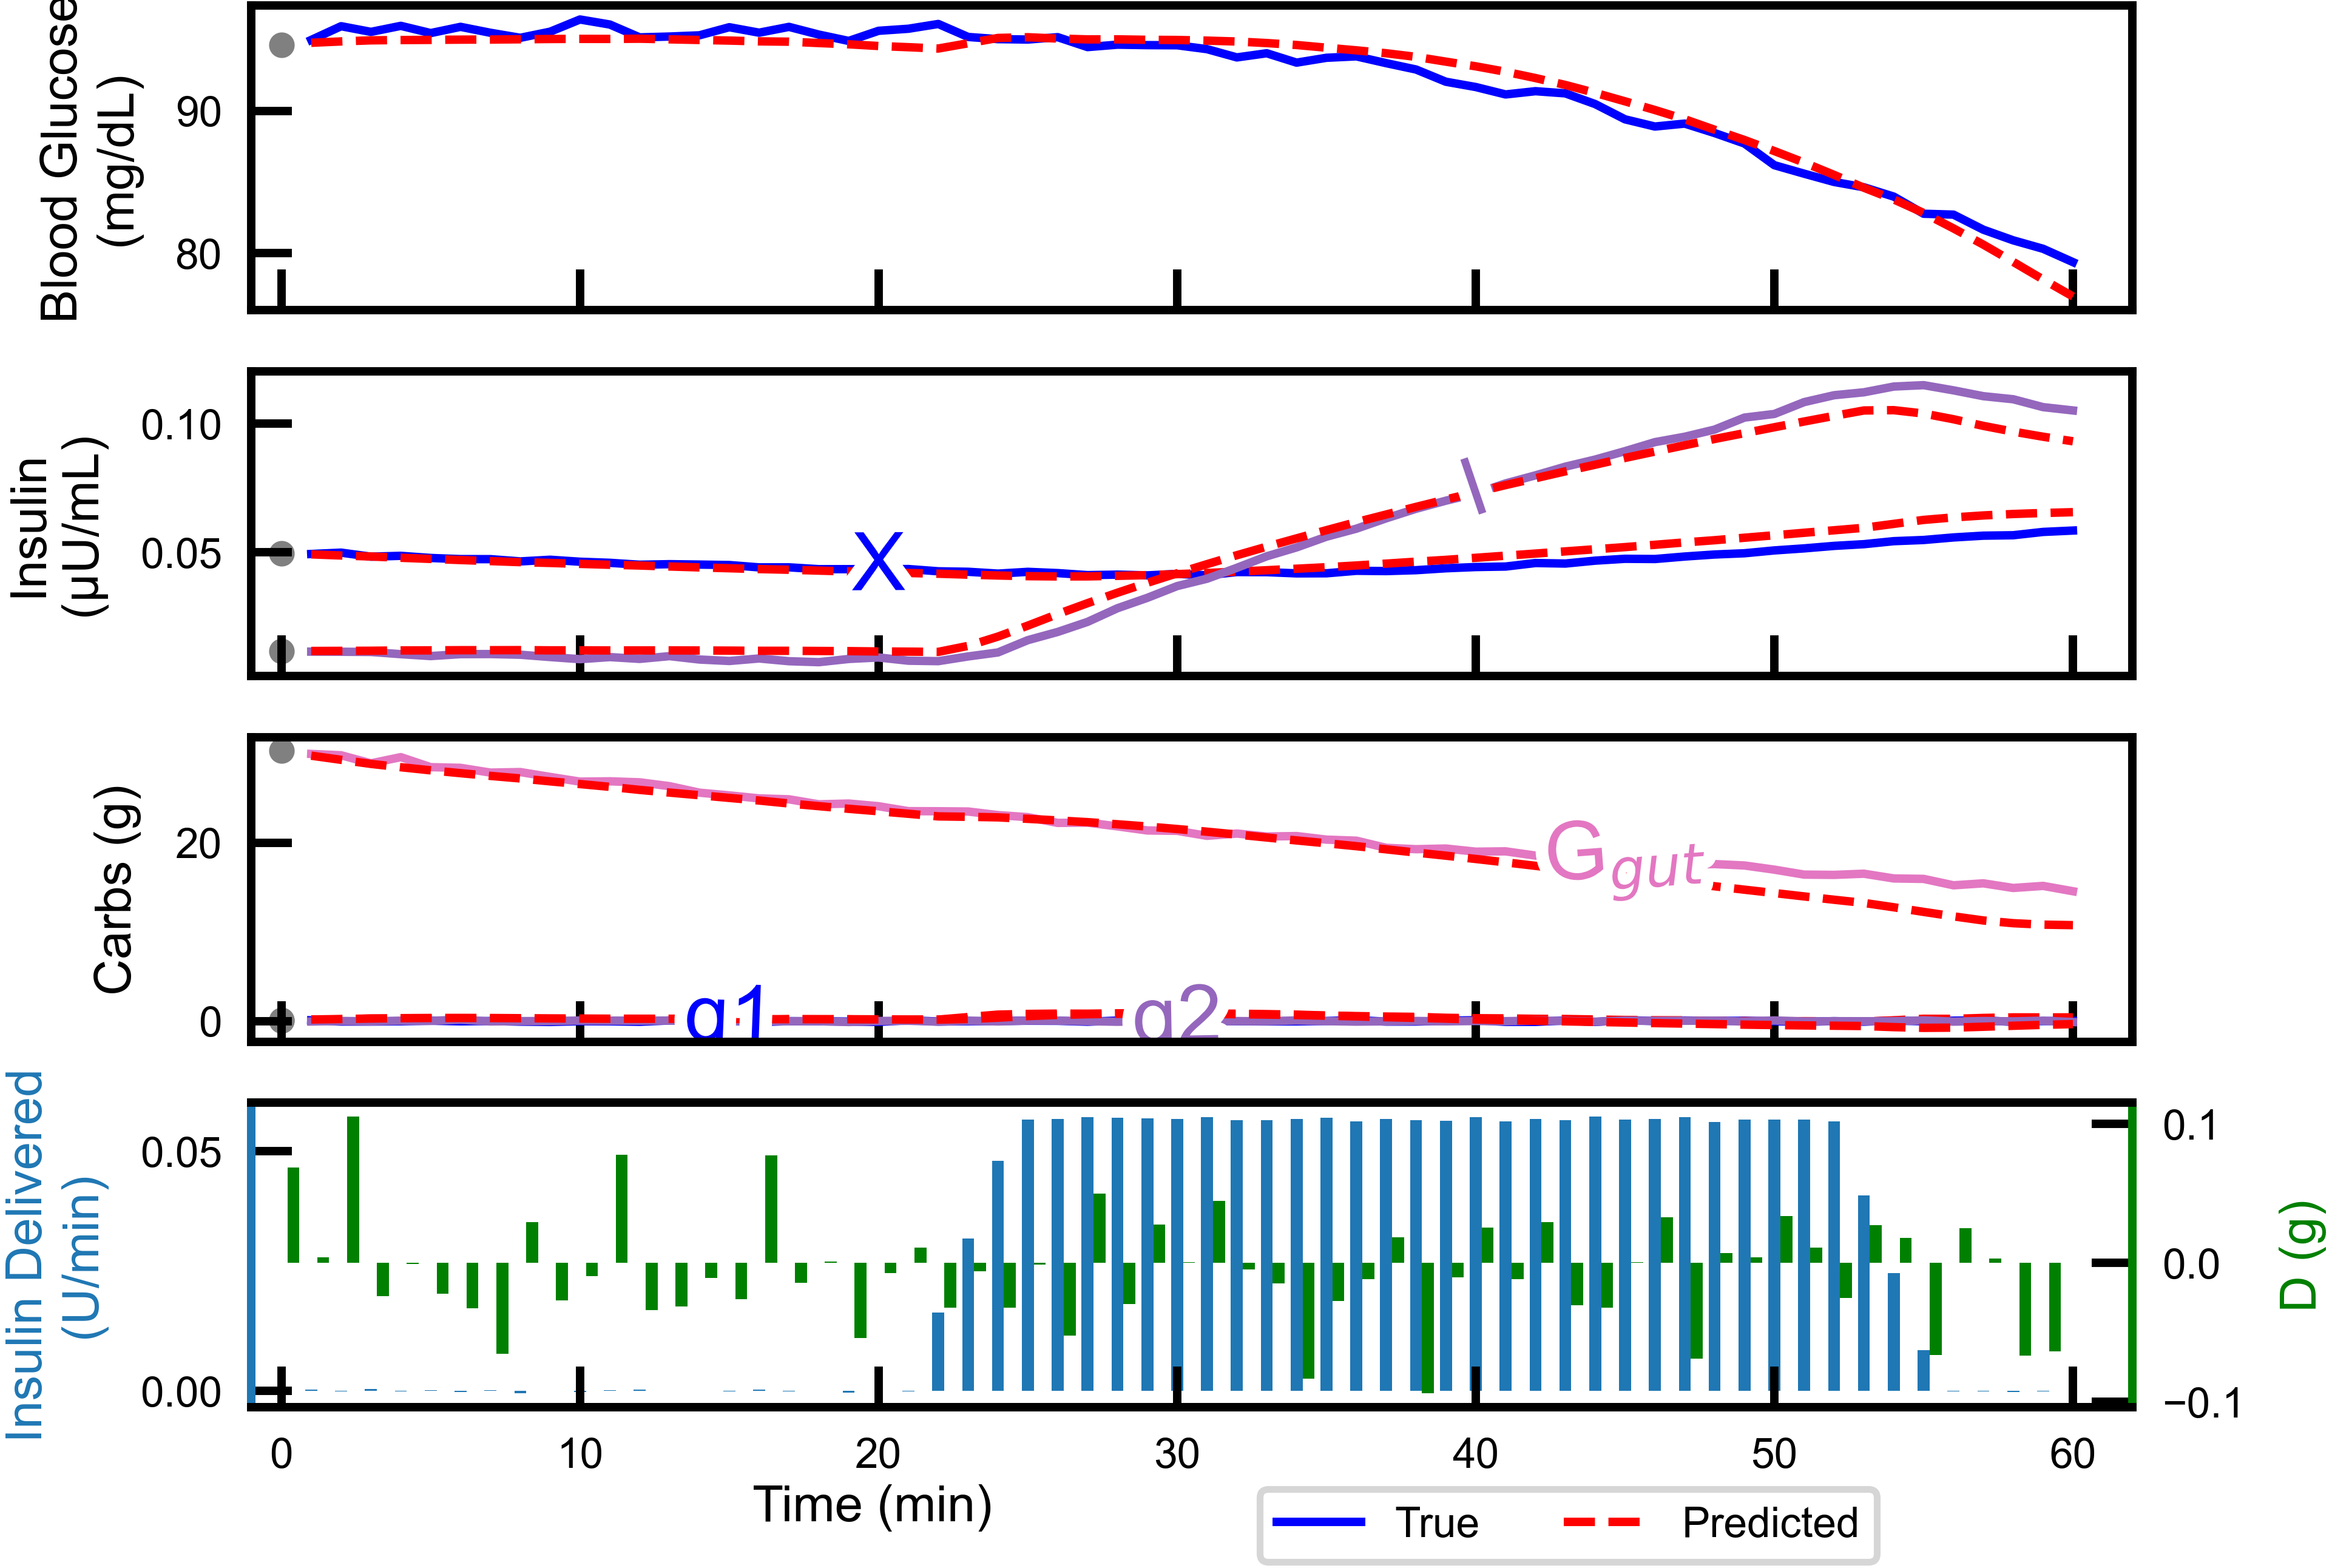

In [8]:
# def plot_predictions(idx, x0, u, x, xp):
# TODO: I,X different colors
# TODO: q1, q2, G_gut different colors
# TODO: Label for glucose Ingestion
# TODO: legend
# TODO: Plot a whole day
# TODO: Smaller Font
def plot_prediction(idx, x0, u, x, xp):
    t = np.arange(60)+1
    scatter_kwargs = dict(c='grey', s=5, label='Initial')
    true_kwargs = dict(c='b')
    pred_kwargs = dict(c='r', linestyle='dashed')
    u0_kwargs = dict(c='g', label='CV')
    u1_kwargs = dict(c='m', label='Bolus')
    bar_width = 0.4
    multipliers = np.array([0,1], dtype=int)

    with plt.rc_context({'lines.linewidth': 1,
        "axes.labelsize": 6,
        "xtick.labelsize": 5,
        "ytick.labelsize": 5}):
        fig, ax = plt.subplots(4, 1, figsize=(4, 3), sharex=True, dpi=1000)
        # G
        ax[0].scatter(0, x0[idx, 0, 0], **scatter_kwargs)
        true_line = ax[0].plot(t, x[idx, :, 0], **true_kwargs)
        predicted_line = ax[0].plot(t, xp[idx, :, 0], **pred_kwargs)
        ax[0].set_ylabel('Blood Glucose\n(mg/dL)')
        # IX  # TODO: label each line
        ax[1].scatter(0, x0[idx, 0, 1], **scatter_kwargs)
        ax1_X = ax[1].plot(t, x[idx, :, 1], label="X", **true_kwargs)
        ax[1].plot(t, xp[idx, :, 1], **pred_kwargs)
        ax[1].scatter(0, x0[idx, 0, 2], **scatter_kwargs)
        ax1_I = ax[1].plot(t, x[idx, :, 2], label="I", c="tab:purple")
        ax[1].plot(t, xp[idx, :, 2], **pred_kwargs)
        ax[1].set_ylabel('Insulin\n(μU/mL)')
        # Q1, Q2, G_gut  TODO: label each line
        ax[2].scatter(0, x0[idx, 0, 3], **scatter_kwargs)
        ax[2].plot(t, x[idx, :, 3], label="q1", **true_kwargs)
        ax[2].plot(t, xp[idx, :, 3], **pred_kwargs)
        ax[2].scatter(0, x0[idx, 0, 4], **scatter_kwargs)
        ax[2].plot(t, x[idx, :, 4], label="q2", c="tab:purple")
        ax[2].plot(t, xp[idx, :, 4], **pred_kwargs)
        ax[2].scatter(0, x0[idx, 0, 5], **scatter_kwargs)
        ax[2].plot(t, x[idx, :, 5], label=r"G$_{gut}$", c="tab:pink")
        ax[2].plot(t, xp[idx, :, 5], **pred_kwargs)
        ax[2].set_ylabel('Carbs (g)')
        # ax[2].set_ylim(ax[2].get_ylim()[0]-5, ax[2].get_ylim()[1]+5)
        # ax[2].yaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
        # ax[2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: int(x)))
        # ax[2].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
        # U[0]: Insulin infusion
        # ax[3].step(t-1, u[idx, :, 0], where="post", **u0_kwargs)
        ax[3].bar(t-1, u[idx, :, 0], width=bar_width, color="tab:blue", label="u")
        ax[3].set_ylabel('Insulin Delivered\n(U/min)', color="tab:blue")
        # ax[3].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
        # D[0]: Meal disturbance
        # ax3 = ax[2].twinx()
        ax3 = ax[3].twinx()
        ax3.bar(t-1+bar_width, u[idx, :, 1], width=bar_width, color="g", label="D")
        ax3.set_ylabel('D (g)', color="g")
        # ax3.set_ylim(-2, 150)
        ax3.spines["right"].set_color("g")
        ax[3].spines["right"].set_color("g")
        ax3.spines["left"].set_color("tab:blue")
        ax[3].spines["left"].set_color("tab:blue")
        # ax[3].yaxis.set_major_locator(mpl.ticker.MultipleLocator(40))
        ax[3].set_xlim(-1, 62)
        ax[3].set_xlabel('Time (min)')
        ax[3].xaxis.set_label_coords(0.33, -.25)
        # ax[3].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
        # ax[3].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: int(x)))
        # ax[3].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))

        ax1_lines = ax[1].get_lines()
        labelLine(ax1_lines[0], 20, outline_width=3)
        labelLine(ax1_lines[2], 40, outline_width=3)
        ax2_lines = ax[2].get_lines()
        labelLine(ax2_lines[0], 15, outline_width=3)
        labelLine(ax2_lines[2], 30, outline_width=3)
        labelLine(ax2_lines[4], 45, outline_width=3)
        
        ax[3].legend([true_line[0], predicted_line[0]], ["True", "Predicted"], loc="upper center", bbox_to_anchor=(0.7, -0.2), ncol=2, fontsize=5)
    return fig, ax

plot_prediction(100, x0, u, x, xp) 

plt.show() 
        

plot predictions of training test, validation

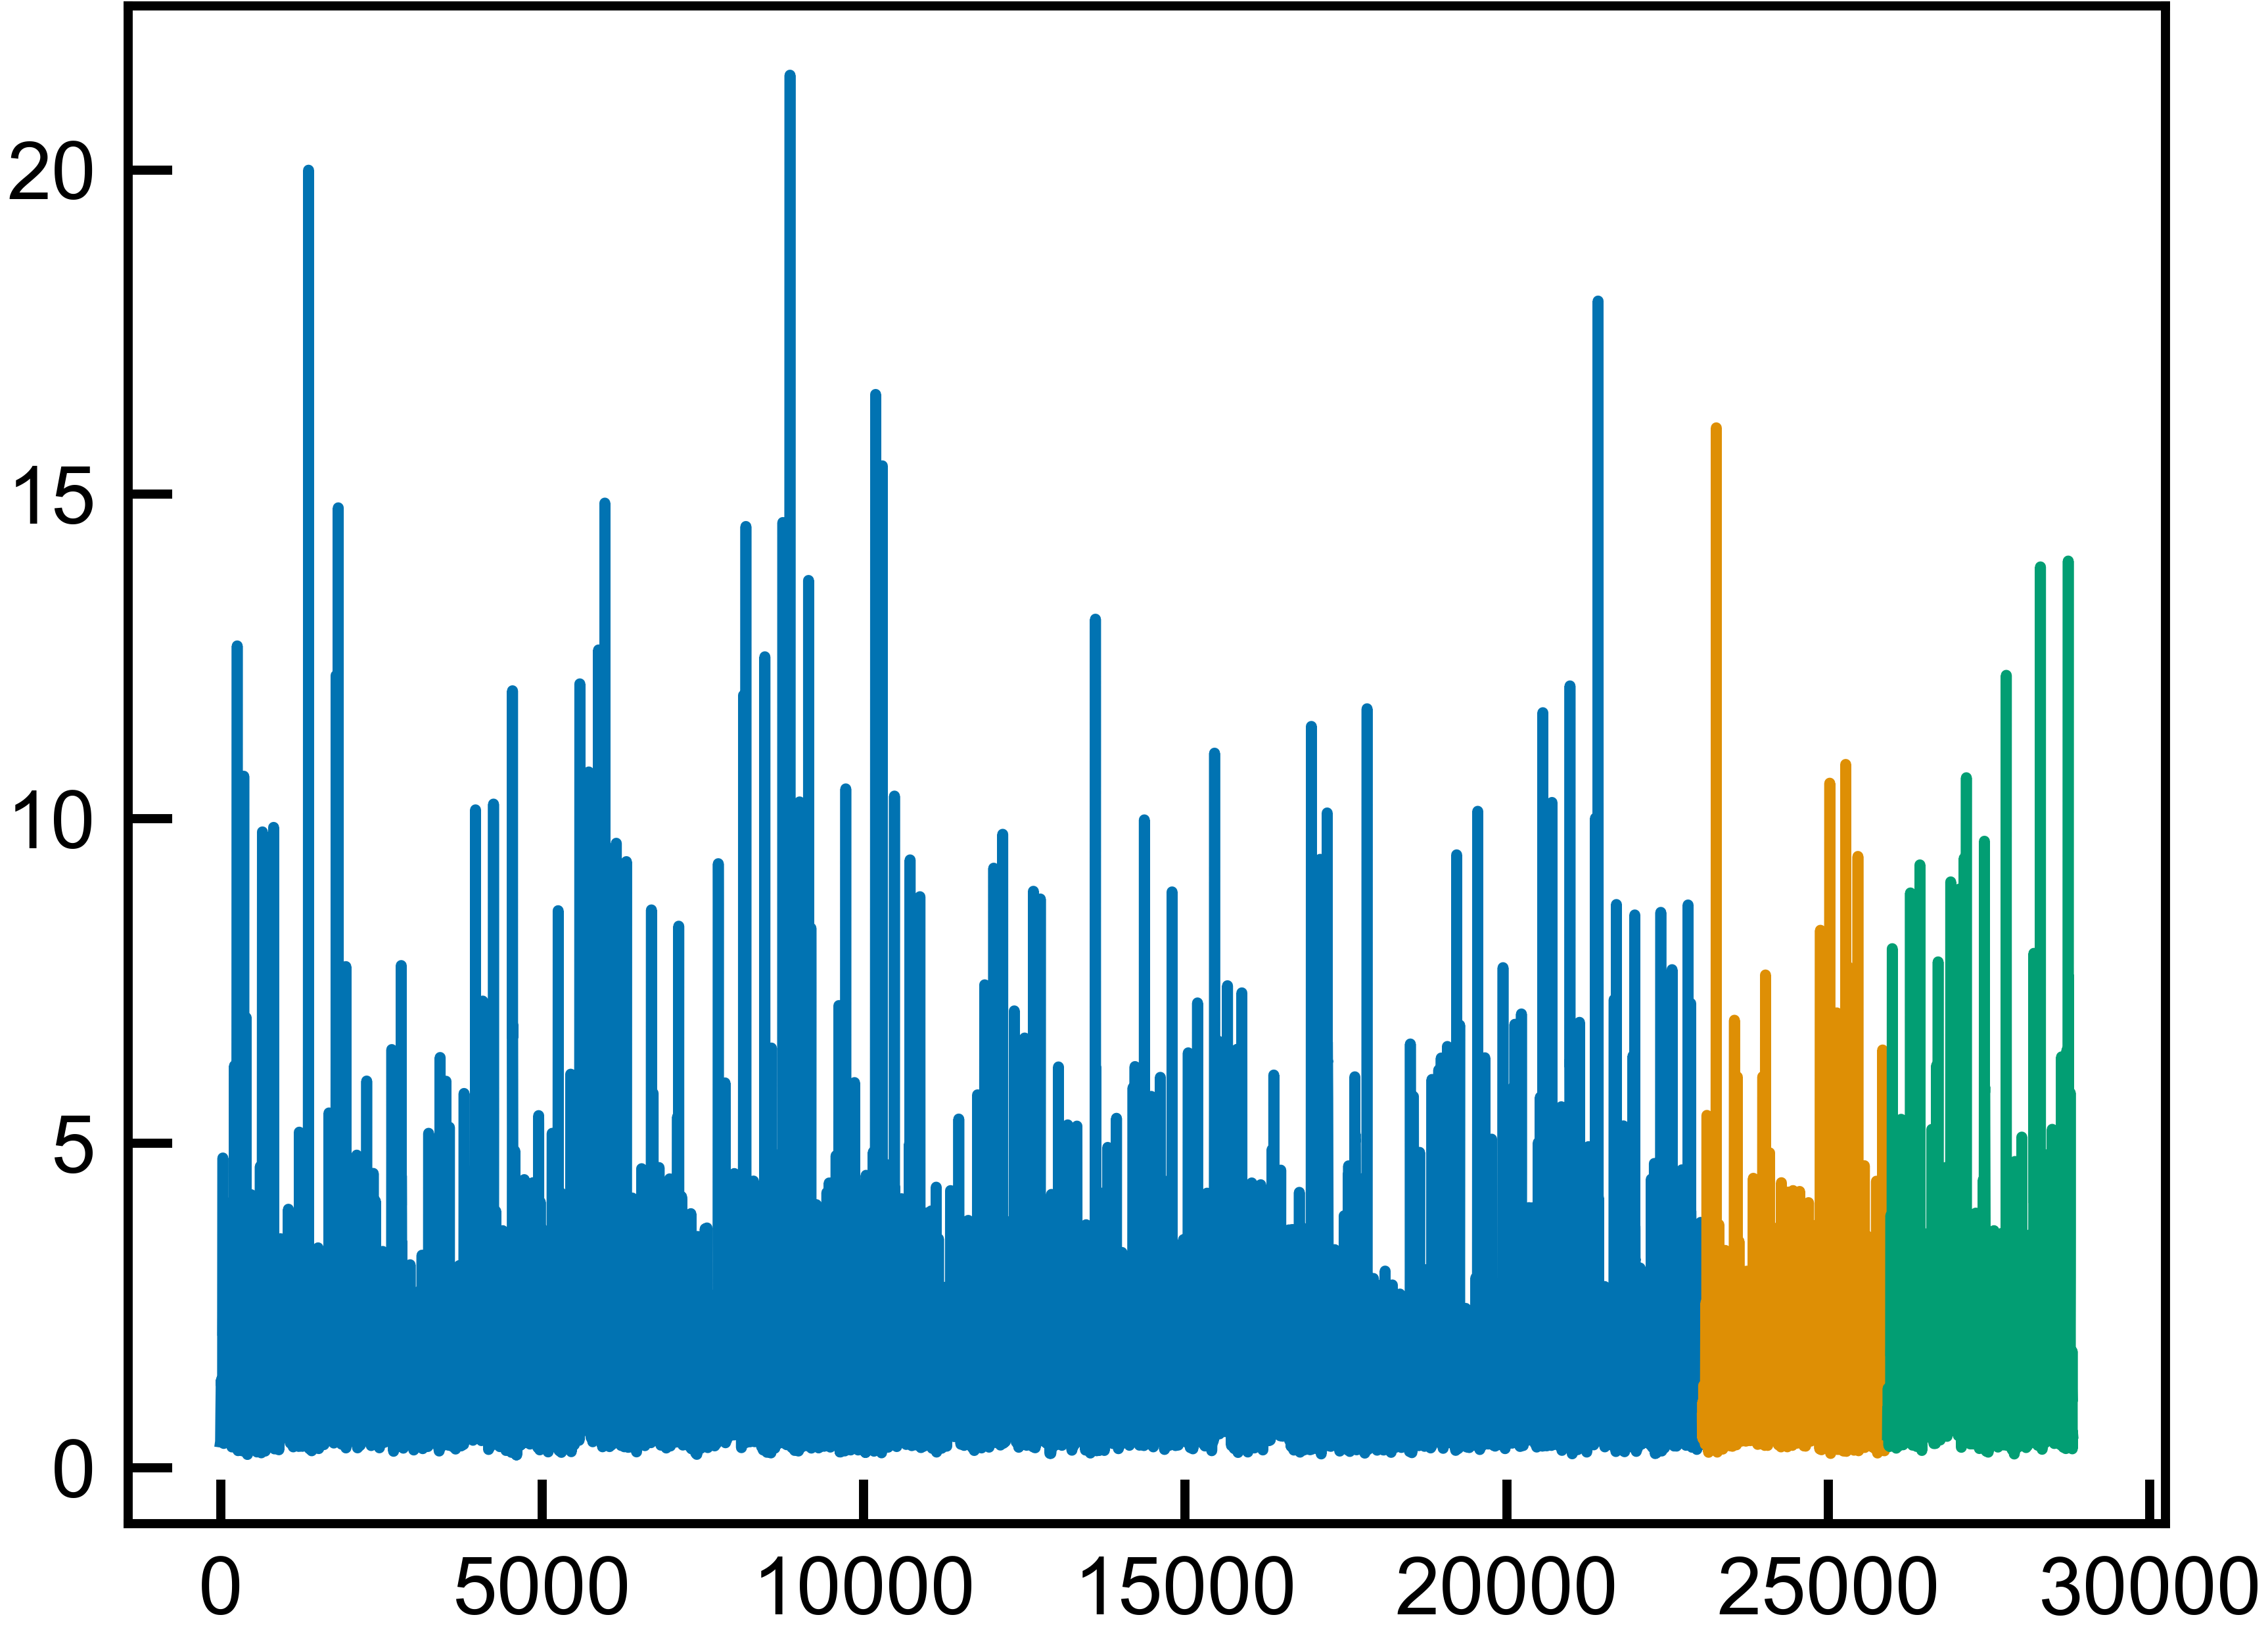

In [9]:
train_out = train_dataset.eval_model(model)
val_out = val_dataset.eval_model(model)
test_out = test_dataset.eval_model(model)

e_train = train_out[2] - train_out[3]
e_val = val_out[2] - val_out[3]
e_test = test_out[2] - test_out[3]

mae_train = np.mean(np.abs(e_train), axis=-1).mean(axis=-1)
mae_val = np.mean(np.abs(e_val), axis=-1).mean(axis=-1)
mae_test = np.mean(np.abs(e_test), axis=-1).mean(axis=-1)

t_train = np.arange(len(e_train))
t_val = np.arange(len(e_val)) + len(t_train)
t_test = np.arange(len(e_test)) + len(e_val) + len(e_train)

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=1000)
ax.plot(t_train, mae_train, label="Train")
ax.plot(t_val, mae_val, label="Val")
ax.plot(t_test, mae_test, label="Test")
plt.show()

finetune on high error samples of training set

In [10]:
# error_quantile = np.quantile(mae_train, 0.9)
# high_error_indices = np.where(mae_train > error_quantile)[0]
# high_error_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2**10, shuffle=False, generator=torch.Generator(device=device), sampler=torch.utils.data.SubsetRandomSampler(high_error_indices))

# early_stopper = EarlyStopper(patience=25)
# criterion = torch.nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)
# checkpointing = True

# finetune_losses = []
# train_losses = []
# val_losses = []
# lrs = []
# epoch = 0
# while not early_stopper():
#     model.train()
#     running_loss = 0
#     for i, batch in enumerate(high_error_dataloader):
#         X0 = batch['X0']
#         U = batch['U']
#         X = batch['X']
        
#         loss = train_minibatch(model, X0, U, X, criterion, optimizer)
#         running_loss += loss
        
#         print(f"\rEpoch [{epoch+1}], Minibatch [{i+1}/{len(high_error_dataloader)}] Finetune: {0 if len(finetune_losses)==0 else finetune_losses[-1]}, Train: {0 if len(train_losses) == 0 else train_losses[-1]:.4g} Val: {0 if len(val_losses) == 0 else val_losses[-1]:.4g} lr: {lr_scheduler.get_last_lr()[0]:.2g}, patience: {early_stopper.counter}",end="")

    
#     # train_loss = running_loss / len(train_dataloader)
#     finetune_loss = val_epoch(model, high_error_dataloader, criterion)
#     train_loss = val_epoch(model, train_dataloader, criterion)
#     val_loss = val_epoch(model, val_dataloader, criterion)
    
#     lr_scheduler.step(finetune_loss)
#     early_stopper.step(val_loss)
    
#     finetune_losses.append(finetune_loss)
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)
#     lrs.append(lr_scheduler.get_last_lr())
    
#     # checkpointing
#     if checkpointing:
#         if train_losses[-1] == min(train_losses):
#             checkpoint = model.state_dict().copy()
    
#     print(f"\rEpoch [{epoch+1}], Minibatch [{i+1}/{len(high_error_dataloader)}] Finetune: {0 if len(finetune_losses)==0 else finetune_losses[-1]}, Train: {0 if len(train_losses) == 0 else train_losses[-1]:.4g} Val: {0 if len(val_losses) == 0 else val_losses[-1]:.4g} lr: {lr_scheduler.get_last_lr()[0]:.2g}, patience: {early_stopper.counter}",end="")
#     epoch += 1

In [11]:
# mse_criterion = torch.nn.MSELoss()
# mae_criterion = torch.nn.L1Loss()

# finetune_mse = val_epoch(model, high_error_dataloader, mse_criterion)
# train_mse = val_epoch(model, train_dataloader, mse_criterion)
# val_mse = val_epoch(model, val_dataloader, mse_criterion)

# finetune_mae = val_epoch(model, high_error_dataloader, mae_criterion)
# train_mae = val_epoch(model, train_dataloader, mae_criterion)
# val_mae = val_epoch(model, val_dataloader, mae_criterion)

# finetune_mse, train_mse, val_mse, finetune_mae, train_mae, val_mae

### Observe gradients & loss Quantiles


In [12]:
# gradients
optimizer = GEKF(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()
datasets = {"train": train_dataset, "val": val_dataset, "test": test_dataset}
for k, ds in datasets.items():
    if not logger.check_key(prefix:=f"training/data w noise/model performance/{k}/"):
        dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=False, generator=torch.Generator(device=device))
        for data in tqdm(dl):
            optimizer.zero_grad()
            X0, U, X = data["X0"], data["U"], data["X"]
            # with torch.no_grad():
            #     j = get_jacobian(model, (X0, U))
            X_pred = model(X0, U)
            innovation = X - X_pred
            loss = criterion(X_pred, X)
            loss.backward()
            grads = get_parameter_gradient_vector(model)
            logger.log_dict({
                prefix+"loss": np.array([loss.item()]),
                prefix+"innovation": innovation.squeeze().detach().cpu().numpy(),
                prefix+"gradients": grads.detach().cpu().numpy(),
                prefix+"X scaled": X.squeeze().detach().cpu().numpy(),
                prefix+"X_pred scaled": X_pred.squeeze().detach().cpu().numpy()
            })
            
# calculate quantile statistics

In [13]:
train_losses = logger.get_dataset("training/data w noise/model performance/train/loss")
train_gradients = logger.get_dataset("training/data w noise/model performance/train/gradients")
val_losses = logger.get_dataset("training/data w noise/model performance/val/loss")
val_gradients = logger.get_dataset("training/data w noise/model performance/val/gradients")
test_losses = logger.get_dataset("training/data w noise/model performance/test/loss")
test_gradients = logger.get_dataset("training/data w noise/model performance/test/gradients")

print("Train".center(30, "="))
print(f"Loss: 99th percentile: {np.quantile(train_losses, 0.99):.4g}, 95th percentile: {np.quantile(train_losses, 0.95):.4g}, 90th percentile: {np.quantile(train_losses, 0.9):.4g}")
print(f"Gradient: 99th percentile: {np.quantile(np.abs(train_gradients), 0.99):.4g}, 95th percentile: {np.quantile(np.abs(train_gradients), 0.95):.4g}, 90th percentile: {np.quantile(train_gradients, 0.9):.4g}")
print("Val".center(30, "="))
print(f"Loss: 99th percentile: {np.quantile(val_losses, 0.99):.4g}, 95th percentile: {np.quantile(val_losses, 0.95):.4g}, 90th percentile: {np.quantile(val_losses, 0.9):.4g}")
print(f"Gradient: 99th percentile: {np.quantile(np.abs(val_gradients), 0.99):.4g}, 95th percentile: {np.quantile(np.abs(val_gradients), 0.95):.4g}, 90th percentile: {np.quantile(val_gradients, 0.9):.4g}")
print("Test".center(30, "="))   
print(f"Loss: 99th percentile: {np.quantile(test_losses, 0.99):.4g}, 95th percentile: {np.quantile(test_losses, 0.95):.4g}, 90th percentile: {np.quantile(test_losses, 0.9):.4g}")
print(f"Gradient: 99th percentile: {np.quantile(np.abs(test_gradients), 0.99):.4g}, 95th percentile: {np.quantile(np.abs(test_gradients), 0.95):.4g}, 90th percentile: {np.quantile(test_gradients, 0.9):.4g}")

loss_threshold = np.quantile(val_losses, 0.99)
m99_gradient = np.quantile(np.abs(val_gradients), 0.99)
m95_gradient = np.quantile(np.abs(val_gradients), 0.95)

del train_losses, train_gradients, val_losses, val_gradients, test_losses, test_gradients

============Train=============
Loss: 99th percentile: 1.118, 95th percentile: 0.2981, 90th percentile: 0.1179
Gradient: 99th percentile: 0.683, 95th percentile: 0.2142, 90th percentile: 0.0522
=============Val==============
Loss: 99th percentile: 1.079, 95th percentile: 0.3337, 90th percentile: 0.1056
Gradient: 99th percentile: 0.6866, 95th percentile: 0.2176, 90th percentile: 0.05261
=============Test=============
Loss: 99th percentile: 1.031, 95th percentile: 0.3095, 90th percentile: 0.1205
Gradient: 99th percentile: 0.6913, 95th percentile: 0.225, 90th percentile: 0.0588


## Drifting

### Decreasing Insulin Sensitivity

TODO: what are the realistic bounds on insulin sensitivity?

Data generation

In [14]:
if not logger.check_key("drifting si/data/t"):
# if True:

    ###
    
    days = 365
    
    dGbdt = 0
    dsidt = -0.4 / (days * 1440)
    dIbdt = 0
    
    ###
    
    P = DiabeticPatient(param_kwargs={"Ib":1e-2})
    
    d = P.get_d(days)
        
    # create time array
    t = np.arange(len(d))

    # insulin
    # 2000 days
    # 1600 training : 200 validation : 200 test
    # 
    u = nd_walk(
        nsim=len(t),
        d=1,
        min=0,
        max=0.1,
        x0=0,
        max_step=0.016,
        p=0.01,
        avoid_edge=False,
        granularity=0
    )[:,0]
    uc = u.copy()

    y0 = np.array([P.Gb, P.Ib, P.Ib, 0, 0, 0, P.Gb, P.si, P.Ib])

    Y = P.sim_safe_patient(y0, t, u, d, [dGbdt, dsidt, dIbdt])
    
    Y = np.array(Y, dtype=np.float32)
    
    G, X, I, Q1, Q2, G_gut, Gb, si, Ib = Y.T
        
    logger.log_dict({
        "drifting si/data/t": t,
        "drifting si/data/D": d,
        "drifting si/data/U": u,
        "drifting si/data/G": G,
        "drifting si/data/X": X,
        "drifting si/data/I": I,
        "drifting si/data/Q1": Q1,
        "drifting si/data/Q2": Q2,
        "drifting si/data/G_gut": G_gut,
        "drifting si/data/Gb": Gb,
        "drifting si/data/si": si,
        "drifting si/data/Ib": Ib
    })
    
    logger.log_dict({
        "drifting si/data w noise/t": t + default_rng.normal(0, NOISE_STD, t.shape) * np.std(t),
        "drifting si/data w noise/D": d + default_rng.normal(0, NOISE_STD, d.shape) * np.std(d),
        "drifting si/data w noise/U": u + default_rng.normal(0, NOISE_STD, u.shape) * np.std(u),
        "drifting si/data w noise/G": G + default_rng.normal(0, NOISE_STD, G.shape) * np.std(G),
        "drifting si/data w noise/X": X + default_rng.normal(0, NOISE_STD, X.shape) * np.std(X),
        "drifting si/data w noise/I": I + default_rng.normal(0, NOISE_STD, I.shape) * np.std(I),
        "drifting si/data w noise/Q1": Q1 + default_rng.normal(0, NOISE_STD, Q1.shape) * np.std(Q1),
        "drifting si/data w noise/Q2": Q2 + default_rng.normal(0, NOISE_STD, Q2.shape) * np.std(Q2),
        "drifting si/data w noise/G_gut": G_gut + default_rng.normal(0, NOISE_STD, G_gut.shape) * np.std(G_gut),
        "drifting si/data w noise/Gb": Gb + default_rng.normal(0, NOISE_STD, Gb.shape) * np.std(Gb),
        "drifting si/data w noise/si": si + default_rng.normal(0, NOISE_STD, si.shape) * np.std(si),
        "drifting si/data w noise/Ib": Ib + default_rng.normal(0, NOISE_STD, Ib.shape) * np.std(Ib)
    })

dataset / control evaluation

In [15]:
# dataset
drifting_si_data = get_glucose_data(logger, "drifting si/data w noise/")
drifting_si_dataset = GlucoseDataset(drifting_si_data,
    prediction_horizon=60,
    input_horizon=1,
    step_size=DATA_STEP_SIZE,
    databounds=[0, 1],
    Xscaler=Xscaler,
    Uscaler=Uscaler
)

# original model evaluation
if not logger.check_key("drifting si/dataset/x0"):
    x0, u, x, xp = drifting_si_dataset.eval_model(model)
    logger.log_attribute("drifting si/dataset/x0", x0)
    logger.log_attribute("drifting si/dataset/u", u)
    logger.log_attribute("drifting si/dataset/x", x)
    logger.log_attribute("drifting si/dataset/x0_scaled", drifting_si_dataset.transform(x0, Xscaler))
    logger.log_attribute("drifting si/dataset/u_scaled", drifting_si_dataset.transform(u, Uscaler))
    logger.log_attribute("drifting si/dataset/x_scaled", drifting_si_dataset.transform(x, Xscaler))
    if not logger.check_key("drifting si/control/xp"):
        logger.log_attribute("drifting si/control/xp", xp)
        logger.log_attribute("drifting si/control/xp_scaled", drifting_si_dataset.transform(xp, Xscaler))

model updating

In [16]:
from utils.modeling import get_jacobian, get_parameter_gradient_vector, mask_fn
from utils.optimizers import GEKF
def sefk_updating_trial(
    drifting_condition, 
    thresh=None, 
    quantile_thresh=None, 
    log_header=None, 
    lr=1e-5, 
    q=0.1, 
    p0=100, 
    logger=None
    ):
    if logger is None:
        logger = h5_logger(os.path.join(results_dir, "data.h5"))
    if log_header is None:
        if thresh is not None:
            log_header = f"{drifting_condition}/updating/t-{thresh:.2f}/"
        elif quantile_thresh is not None:
            log_header = f"{drifting_condition}/updating/q-{quantile_thresh:.2f}/"
        else:
            log_header = f"{drifting_condition}/updating/full/"
    print(log_header)
    if not logger.check_key(log_header+"xp"):
        drifting_data = get_glucose_data(logger, f"{drifting_condition}/data w noise/")
        drifting_dataset = GlucoseDataset(drifting_data,
            prediction_horizon=60,
            input_horizon=1,
            step_size=DATA_STEP_SIZE,
            databounds=[0, 1],
            Xscaler=Xscaler,
            Uscaler=Uscaler
        )
        drifting_dataloader = torch.utils.data.DataLoader(drifting_dataset, batch_size=1, shuffle=False, generator=torch.Generator(device=device))

        model = torch.load(os.path.join(results_dir, "model.pth"), map_location=device)
        optimizer = GEKF(model.parameters(), lr=lr, q=q, p0=p0)
        criterion = torch.nn.MSELoss()

        logger.log_attribute(log_header+"parameters/lr", np.array([lr]))
        logger.log_attribute(log_header+"parameters/q", np.array([q]))
        logger.log_attribute(log_header+"parameters/p0", np.array([p0]))

        start_time = time.time()

        model.train()
        pbar = tqdm(drifting_dataloader, desc=log_header)
        for data in pbar:
            optimizer.zero_grad()
            X0, U, X = data["X0"], data["U"], data["X"]
            with torch.no_grad():
                j = get_jacobian(model, (X0, U))
            X_pred = model(X0, U)
            innovation = X - X_pred
            loss = criterion(X_pred, X)
            loss.backward()
            grads = get_parameter_gradient_vector(model)
            mask = mask_fn(grads, thresh=thresh, quantile_thresh=quantile_thresh)
            optimizer.step(innovation, j, mask)
            pbar.set_description(f"{log_header} Loss: {np.mean(loss.item()):.4f}")
            
            logger.log_dict({
                log_header+"x0": X0.detach().cpu().numpy(),
                log_header+"u": U.detach().cpu().numpy(),
                log_header+"x": X.detach().cpu().numpy(),
                log_header+"xp": X_pred.detach().cpu().numpy(),
                log_header+"innovation": innovation.detach().cpu().numpy(),
                log_header+"loss": np.mean(loss.item()),
                log_header+"mask": mask.detach().cpu().numpy(),
                log_header+"weights": optimizer._get_flat_params().detach().cpu().numpy(),
                log_header+"time": np.array([time.time() - start_time])
            })
            
sefk_updating_trial(
    drifting_condition="drifting si",
    thresh=None,
    quantile_thresh=None,
    lr=1e-5,
    q=0.1,
    p0=100,
    logger=logger
)

sefk_updating_trial(
    log_header="drifting si/updating/t-0.99/",
    drifting_condition="drifting si",
    thresh=m99_gradient,
    quantile_thresh=None,
    lr=1e-5,
    q=0.1,
    p0=100,
    logger=logger
)

sefk_updating_trial(
    log_header="drifting si/updating/t-0.95/",
    drifting_condition="drifting si",
    thresh=m95_gradient,
    quantile_thresh=None,
    lr=1e-5,
    q=0.1,
    p0=100,
    logger=logger
)
sefk_updating_trial(
    drifting_condition="drifting si",
    thresh=None,
    quantile_thresh=0.99,
    lr=1e-5,
    q=0.1,
    p0=100,
    logger=logger
)
sefk_updating_trial(
    drifting_condition="drifting si",
    thresh=None,
    quantile_thresh=0.95,
    lr=1e-5,
    q=0.1,
    p0=100,
    logger=logger
)

drifting si/updating/full/
drifting si/updating/t-0.99/
drifting si/updating/t-0.95/
drifting si/updating/q-0.99/
drifting si/updating/q-0.95/


In [19]:
from utils.optimizers import maskedAdam
from utils.modeling import get_parameter_gradient_vector, mask_fn

# Retraining
def adam_retraining_trial(
    drifting_condition="drifting si",
    thresh=None,
    quantile_thresh=None,
    lr=1e-5,

    loss_threshold=0.06,
    moving_horizon_length=50,
    retraining_batch_size=5,
    retraining_epochs=50,

    early_stopping_threshold=0,
    divergence_threshold=20,

    logger=logger,
    log_header=None,
    find_unique_header=True
    ):
    # ---
    ### initialize ###
    if log_header is None:
        if thresh is not None:
            log_header = f"{drifting_condition}/retraining/t-{thresh:.2f}/"
        elif quantile_thresh is not None:
            log_header = f"{drifting_condition}/retraining/q-{quantile_thresh:.2f}/"
        else:
            log_header = f"{drifting_condition}/retraining/full/"
    if find_unique_header:
        log_header = logger.get_unique_key(log_header)
    if not logger.check_key(log_header+"xp"):
        # create dataset
        drifting_data = get_glucose_data(logger, f"{drifting_condition}/data w noise/")
        drifting_dataset = GlucoseDataset(drifting_data,
            prediction_horizon=60,
            input_horizon=1,
            step_size=DATA_STEP_SIZE,
            databounds=[0, 1],
            Xscaler=Xscaler,
            Uscaler=Uscaler
        )
        drifting_dataloader = torch.utils.data.DataLoader(drifting_dataset, batch_size=1, shuffle=False, generator=torch.Generator(device=device))
        
        # initialize other stuff
        model = torch.load(os.path.join(results_dir, "model.pth"), map_location=device)
        optimizer = maskedAdam(model.parameters(), lr=lr)
        criterion = torch.nn.MSELoss()

        # log conditions
        # loss_threshold=0.2
        # moving_horizon_length=50
        # retraining_batch_size=5
        # retraining_epochs=50

        # early_stopping_threshold=0
        # divergence_threshold=99
        logger.log_attribute(log_header+"parameters/lr", np.array([lr]))
        logger.log_attribute(log_header+"parameters/loss_threshold", np.array([loss_threshold]))
        logger.log_attribute(log_header+"parameters/moving_horizon_length", np.array([moving_horizon_length]))
        logger.log_attribute(log_header+"parameters/retraining_batch_size", np.array([retraining_batch_size]))
        logger.log_attribute(log_header+"parameters/retraining_epochs", np.array([retraining_epochs]))
        logger.log_attribute(log_header+"parameters/early_stopping_threshold", np.array([early_stopping_threshold]))
        logger.log_attribute(log_header+"parameters/divergence_threshold", np.array([divergence_threshold]))
        logger.log_attribute(log_header+"parameters/early_stopping_threshold", np.array([early_stopping_threshold]))

        start_time = time.time()

        model.train()
        pbar = tqdm(enumerate(drifting_dataloader), desc=log_header, total=len(drifting_dataloader))
        for i, data in pbar:
            optimizer.zero_grad()
            X0, U, X = data["X0"], data["U"], data["X"]
            X_pred = model(X0, U)
            loss = criterion(X_pred, X)
            # loss.backward()
            # grads = get_parameter_gradient_vector(model)
            # mask = mask_fn(grads, thresh=thresh, quantile_thresh=quantile_thresh)
            # optimizer.step(innovation, j, mask)
            pbar.set_description(f"{log_header} Loss: {np.mean(loss.item()):.4f}")
            
            logger.log_dict({
                log_header+"x0": X0.detach().cpu().numpy(),
                log_header+"u": U.detach().cpu().numpy(),
                log_header+"x": X.detach().cpu().numpy(),
                log_header+"xp": X_pred.detach().cpu().numpy(),
                # log_header+"innovation": innovation.detach().cpu().numpy(),
                log_header+"loss": np.mean(loss.item()),
                # log_header+"mask": mask.detach().cpu().numpy(),
                # log_header+"weights": optimizer._get_flat_params().detach().cpu().numpy(),
                # log_header+"time": np.array([time.time() - start_time])
            })
            
            ### retraining ###
            if loss.item() > loss_threshold:
                # backpropagate
                loss.backward()
                grads = get_parameter_gradient_vector(model)
                mask = mask_fn(grads, thresh=thresh, quantile_thresh=quantile_thresh)
                
                # reinitialize optimizer to reset momentum
                # optimizer = maskedAdam(model.parameters(), lr=lr)
                
                moving_horizon_start = i - moving_horizon_length if i > moving_horizon_length else 0
                retraining_indices = np.arange(moving_horizon_start, i)
                # retraining_losses = []
                retraining_sampler = torch.utils.data.SubsetRandomSampler(retraining_indices, generator=torch.Generator(device=device))
                retraining_dataloader = torch.utils.data.DataLoader(drifting_dataset, batch_size=retraining_batch_size, sampler=retraining_sampler)
                for retraining_epoch in range(retraining_epochs):
                    for retraining_batch in retraining_dataloader:
                        optimizer.zero_grad()
                        X0, U, X = retraining_batch["X0"], retraining_batch["U"], retraining_batch["X"]
                        X_pred = model(X0, U)
                        retraining_loss = criterion(X_pred, X)
                        retraining_loss.backward()
                        optimizer.masked_step(mask=mask)
                        # retraining_losses.append(retraining_loss.item())
                        if retraining_loss.item() < early_stopping_threshold:
                            break
                    # if retraining_loss.item() < early_stopping_threshold:
                    #     break
                logger.log_dict({
                    log_header+"grads":grads.detach().cpu().numpy(),
                    log_header+"mask":mask.detach().cpu().numpy(),
                })
            
            # log time after retraining
            logger.log_dict({
                log_header+"time": np.array([time.time() - start_time])
            })
            
            pbar.set_description(f"{log_header} Loss: {np.mean(loss.item()):.4f}")
            
            ### check for divergence ###
            if (loss.item() > divergence_threshold) or np.isnan(loss.item()):
                print(f" {log_header} Diverged ".center(40, "="))
                logger.append_group_name(log_header, suffix="diverged")
                # return None

loss_threshold = 0.68
adam_lr = 3e-5
retraining_epochs = 50

adam_retraining_trial(
    drifting_condition="drifting si",
    thresh=None,
    quantile_thresh=None,
    lr=adam_lr,

    loss_threshold=loss_threshold,
    moving_horizon_length=50,
    retraining_batch_size=5,
    retraining_epochs=retraining_epochs,

    early_stopping_threshold=0,
    divergence_threshold=99,

    logger=logger,
    log_header=None,
    find_unique_header=False
    )

adam_retraining_trial(
    drifting_condition="drifting si",
    thresh=None,
    quantile_thresh=0.99,
    lr=adam_lr,

    loss_threshold=loss_threshold,
    moving_horizon_length=50,
    retraining_batch_size=5,
    retraining_epochs=retraining_epochs,

    early_stopping_threshold=0,
    divergence_threshold=99,

    logger=logger,
    log_header=None,
    find_unique_header=False
    )

adam_retraining_trial(
    drifting_condition="drifting si",
    thresh=None,
    quantile_thresh=0.95,
    lr=adam_lr,

    loss_threshold=loss_threshold,
    moving_horizon_length=50,
    retraining_batch_size=5,
    retraining_epochs=retraining_epochs,

    early_stopping_threshold=0,
    divergence_threshold=99,

    logger=logger,
    log_header=None,
    find_unique_header=False
    )

adam_retraining_trial(
    drifting_condition="drifting si",
    log_header="drifting si/retraining/t-0.99/",
    thresh=m99_gradient,
    quantile_thresh=None,
    lr=adam_lr,

    loss_threshold=loss_threshold,
    moving_horizon_length=50,
    retraining_batch_size=5,
    retraining_epochs=retraining_epochs,

    early_stopping_threshold=0,
    divergence_threshold=99,

    logger=logger,
    find_unique_header=False
    )

adam_retraining_trial(
    drifting_condition="drifting si",
    log_header="drifting si/retraining/t-0.95/",
    thresh=m95_gradient,
    quantile_thresh=None,
    lr=adam_lr,

    loss_threshold=loss_threshold,
    moving_horizon_length=50,
    retraining_batch_size=5,
    retraining_epochs=retraining_epochs,

    early_stopping_threshold=0,
    divergence_threshold=99,

    logger=logger,
    find_unique_header=False
    )


C:\Users\jhamm\AppData\Local\Temp\ipykernel_30564\840115764.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(results_dir, "model.pth"), m

drifting si/retraining/full/:   0%|          | 0/5255 [00:00<?, ?it/s]

C:\Users\jhamm\AppData\Local\Temp\ipykernel_30564\840115764.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(results_dir, "model.pth"), m

drifting si/retraining/q-0.99/:   0%|          | 0/5255 [00:00<?, ?it/s]

C:\Users\jhamm\AppData\Local\Temp\ipykernel_30564\840115764.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(results_dir, "model.pth"), m

drifting si/retraining/q-0.95/:   0%|          | 0/5255 [00:00<?, ?it/s]

C:\Users\jhamm\AppData\Local\Temp\ipykernel_30564\840115764.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(results_dir, "model.pth"), m

drifting si/retraining/t-0.99/:   0%|          | 0/5255 [00:00<?, ?it/s]

C:\Users\jhamm\AppData\Local\Temp\ipykernel_30564\840115764.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(results_dir, "model.pth"), m

drifting si/retraining/t-0.95/:   0%|          | 0/5255 [00:00<?, ?it/s]

In [18]:
# logger.recursive_del("drifting si/retraining/")

### Figures
plots of loss over time

In [ ]:
xp_control = logger.get_dataset("drifting si/control/xp")
x_control = logger.get_dataset("drifting si/dataset/x")
# xp_updating = drifting_si_dataset.inverse_transform(logger.get_dataset(log_header+"xp")[:,0], Xscaler)
# x_updating = drifting_si_dataset.inverse_transform(logger.get_dataset(log_header+"x")[:,0], Xscaler)
control_loss = ((xp_control - x_control)**2).mean(axis=-1)
# updating_loss = ((xp_updating - x_updating)**2).mean(axis=-1).mean(axis=-1)

# fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=1000)
# ax.plot(control_loss, label="Control")
# ax.plot(updating_loss, label="Updating")
# ax.legend()
# plt.show()

In [ ]:
np.quantile(control_loss.mean(axis=-1)[:200], 0.99)

In [ ]:
xp_control = logger.get_dataset("drifting si/control/xp_scaled")
x_control = logger.get_dataset("drifting si/dataset/x_scaled")
# xp_updating = drifting_si_dataset.inverse_transform(logger.get_dataset(log_header+"xp")[:,0], Xscaler)
# x_updating = drifting_si_dataset.inverse_transform(logger.get_dataset(log_header+"x")[:,0], Xscaler)
xp_updating = logger.get_dataset(log_header+"xp")
x_updating = logger.get_dataset(log_header+"x")
control_loss = ((xp_control - x_control)**2).mean(axis=-1).mean(axis=-1)
updating_loss = ((xp_updating - x_updating)**2).mean(axis=-1).mean(axis=-1)
x_training = logger.get_dataset("training/model performance/training dataset/x_scaled")
xp_training = logger.get_dataset("training/model performance/training dataset/xp_scaled")
training_loss = ((xp_training - x_training)**2).mean(axis=-1).mean(axis=-1)

t_training = np.arange(len(training_loss))
t_drifting = np.arange(len(training_loss), len(training_loss) + len(updating_loss))

fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=1000)
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=1000)
ax.plot(t_training, training_loss, label="Training")
ax.plot(t_drifting, control_loss, label="Control")
ax.plot(t_drifting, updating_loss, label="Updating")
ax.legend()
plt.show()

In [ ]:
control_loss.mean(), updating_loss.mean(), training_loss.mean(), updating_loss.mean() / control_loss.mean()

In [ ]:
np.where(control_loss > 5)
i = 3506
plt.plot(drifting_si_dataset.transform(x_control[i], Xscaler))
plt.plot(drifting_si_dataset.transform(xp_control[i], Xscaler), linestyle=":")
plt.show()

### Decreasing Basal Insulin Production Rate

In [ ]:
days = 365

dGbdt = 0
dsidt = 0
dIbdt = 0

###

P = DiabeticPatient(param_kwargs={"Ib":1e-2})

d = P.get_d(days)
    
# create time array
t = np.arange(len(d))

# insulin
# 2000 days
# 1600 training : 200 validation : 200 test
# 
u = nd_walk(
    nsim=len(t),
    d=1,
    min=0,
    max=0.1,
    x0=0,
    max_step=0.016,
    p=0.01,
    avoid_edge=False,
    granularity=0
)[:,0]

y0 = np.array([P.Gb, P.Ib, P.Ib, 0, 0, 0, P.Gb, P.si, P.Ib])

Y = P.sim_safe_patient(y0, t, u, d, [dGbdt, dsidt, dIbdt])

Y = np.array(Y, dtype=np.float32)

G, X, I, Q1, Q2, G_gut, Gb, si, Ib = Y.T

# drifting_ib_data = get_glucose_data(logger, "drifting Ib/data/")
drifting_ib_data = {
        'D': d, 
        'U': u,
        'G': G,
        'X': X,
        'I': I,
        'Q1': Q1,
        'Q2': Q2,
        'G_gut': G_gut
    }
drifting_ib_dataset = GlucoseDataset(drifting_ib_data,
    prediction_horizon=60,
    input_horizon=1,
    step_size=DATA_STEP_SIZE,
    databounds=[0, 1],
    Xscaler=Xscaler,
    Uscaler=Uscaler
)

x0, u, x, xp = drifting_ib_dataset.eval_model(model)

In [83]:
x = drifting_ib_dataset.transform(x, Xscaler)
xp = drifting_ib_dataset.transform(xp, Xscaler)
u = drifting_ib_dataset.transform(u, Uscaler)
x0 = drifting_ib_dataset.transform(x0, Xscaler)

In [ ]:
idx = idx + 2

t = np.arange(60)+1
scatter_kwargs = dict(c='grey', s=5, label='Initial')
true_kwargs = dict(c='b')
pred_kwargs = dict(c='r', linestyle='dashed')
u0_kwargs = dict(c='g', label='CV')
u1_kwargs = dict(c='m', label='Bolus')
bar_width = 0.4
multipliers = np.array([0,1], dtype=int)

with plt.rc_context({'lines.linewidth': 1,
    "axes.labelsize": 6,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5}):
    fig, ax = plt.subplots(4, 1, figsize=(4, 3), sharex=True, dpi=1000)
    # G
    ax[0].scatter(0, x0[idx, 0, 0], **scatter_kwargs)
    true_line = ax[0].plot(t, x[idx, :, 0], **true_kwargs)
    predicted_line = ax[0].plot(t, xp[idx, :, 0], **pred_kwargs)
    ax[0].set_ylabel('Blood Glucose\n(mg/dL)')
    # IX  # TODO: label each line
    ax[1].scatter(0, x0[idx, 0, 1], **scatter_kwargs)
    ax1_X = ax[1].plot(t, x[idx, :, 1], label="X", **true_kwargs)
    ax[1].plot(t, xp[idx, :, 1], **pred_kwargs)
    ax[1].scatter(0, x0[idx, 0, 2], **scatter_kwargs)
    ax1_I = ax[1].plot(t, x[idx, :, 2], label="I", c="tab:purple")
    ax[1].plot(t, xp[idx, :, 2], **pred_kwargs)
    ax[1].set_ylabel('Insulin\n(μU/mL)')
    # Q1, Q2, G_gut  TODO: label each line
    ax[2].scatter(0, x0[idx, 0, 3], **scatter_kwargs)
    ax[2].plot(t, x[idx, :, 3], label="q1", **true_kwargs)
    ax[2].plot(t, xp[idx, :, 3], **pred_kwargs)
    ax[2].scatter(0, x0[idx, 0, 4], **scatter_kwargs)
    ax[2].plot(t, x[idx, :, 4], label="q2", c="tab:purple")
    ax[2].plot(t, xp[idx, :, 4], **pred_kwargs)
    ax[2].scatter(0, x0[idx, 0, 5], **scatter_kwargs)
    ax[2].plot(t, x[idx, :, 5], label=r"G$_{gut}$", c="tab:pink")
    ax[2].plot(t, xp[idx, :, 5], **pred_kwargs)
    ax[2].set_ylabel('Carbs (g)')
    # ax[2].set_ylim(ax[2].get_ylim()[0]-5, ax[2].get_ylim()[1]+5)
    # ax[2].yaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
    # ax[2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: int(x)))
    # ax[2].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
    # U[0]: Insulin infusion
    # ax[3].step(t-1, u[idx, :, 0], where="post", **u0_kwargs)
    ax[3].bar(t-1, u[idx, :, 0], width=bar_width, color="tab:blue", label="u")
    ax[3].set_ylabel('Insulin Delivered\n(U/min)', color="tab:blue")
    # ax[3].set_ylim(-0.01, 0.1)
    # ax[3].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
    # D[0]: Meal disturbance
    # ax3 = ax[2].twinx()
    ax3 = ax[3].twinx()
    ax3.bar(t-1+bar_width, u[idx, :, 1], width=bar_width, color="g", label="D")
    ax3.set_ylabel('D (g)', color="g")
    # ax3.set_ylim(-2, 150)
    ax3.spines["right"].set_color("g")
    ax[3].spines["right"].set_color("g")
    ax3.spines["left"].set_color("tab:blue")
    ax[3].spines["left"].set_color("tab:blue")
    # ax[3].yaxis.set_major_locator(mpl.ticker.MultipleLocator(40))
    ax[3].set_xlim(-1, 62)
    ax[3].set_xlabel('Time (min)')
    ax[3].xaxis.set_label_coords(0.33, -.25)
    # ax[3].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    # ax[3].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: int(x)))
    # ax[3].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))

    ax1_lines = ax[1].get_lines()
    labelLine(ax1_lines[0], 20, outline_width=3)
    labelLine(ax1_lines[2], 40, outline_width=3)
    ax2_lines = ax[2].get_lines()
    labelLine(ax2_lines[0], 15, outline_width=3)
    labelLine(ax2_lines[2], 30, outline_width=3)
    labelLine(ax2_lines[4], 45, outline_width=3)
    
    ax[3].legend([true_line[0], predicted_line[0]], ["True", "Predicted"], loc="upper center", bbox_to_anchor=(0.7, -0.2), ncol=2, fontsize=5)
plt.show()     

In [ ]:
logger.get_keys("drifting si/data w noise/")